In [1]:
# Load radargrams over David Glacier from KOPRI
# Uses manually edited version of impdar to read segy files using endian='big' instead of the default 'little'

from impdar.lib import load, plot # Use obspy instead as segy
from obspy.io.segy.core import _read_segy
import os
from impdar.lib.plot import plot_traces, plot_radargram

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import cartopy.crs as ccrs

import segyio
import shapefile
import shapely
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

In [3]:
# Load with impdar
file_paths = [os.path.join('./_data/IPR_2018-2019', f) for f in os.listdir('./_data/IPR_2018-2019') if f.endswith('.segy')]
file_paths.sort()
radargrams_18_19 = [load.load('segy',file_paths[i]) for i in range(len(file_paths[:]))]

# Load with impdar
file_paths_16_17 = [os.path.join('./_data/IPR_2016-2017', f) for f in os.listdir('./_data/IPR_2016-2017') if f.endswith('.segy')]
file_paths_16_17.sort()
radargrams_16_17 = [load.load('segy',file_paths_16_17[i]) for i in range(len(file_paths_16_17[:]))]

In [1]:
# Load utig netcdf
import xarray as xr
utig_path = './_data/UTG_David/*.nc'
utig_radargram = xr.open_mfdataset(utig_path, combine='by_coords')


/tmp/ipykernel_9613/3917354515.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  utig_radargram = xr.open_mfdataset(utig_path, combine='by_coords')
/tmp/ipykernel_9613/3917354515.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  utig_radargram = xr.open_mfdataset(utig_path, combine='by_coords')
/tmp/ipykernel_9613/3917354515.py:4: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  utig_radargram = xr.open_mfdataset(utig_path, combine='by_coords')


In [2]:
utig_radargram

<xarray.Dataset> Size: 560MB
Dimensions:              (time: 10926, fasttime_dim: 3200)
Coordinates:
  * time                 (time) datetime64[ns] 87kB 2017-01-20T23:29:48.68750...
Dimensions without coordinates: fasttime_dim
Data variables:
    fasttime             (time, fasttime_dim) timedelta64[ns] 280MB dask.array<chunksize=(4000, 3200), meta=np.ndarray>
    lat                  (time) float32 44kB dask.array<chunksize=(4000,), meta=np.ndarray>
    lon                  (time) float32 44kB dask.array<chunksize=(4000,), meta=np.ndarray>
    altitude             (time) float32 44kB dask.array<chunksize=(4000,), meta=np.ndarray>
    pitch                (time) float32 44kB dask.array<chunksize=(4000,), meta=np.ndarray>
    roll                 (time) float32 44kB dask.array<chunksize=(4000,), meta=np.ndarray>
    heading              (time) float32 44kB dask.array<chunksize=(4000,), meta=np.ndarray>
    amplitude_low_gain   (time, fasttime_dim) float32 140MB dask.array<chunksize=(4000, 3200), meta=np.ndarray>
    amplitude_high_gain  (time, fasttime_dim) float32 140MB dask.array<chunksize=(4000, 3200), meta=np.ndarray>
Attributes: (12/27)
    featureType:          timeSeries
    location:             ZK-IBH
    source:               airborne ice penetrating radar
    data_version:         JUN292018
    netcdf_version:       4.1.2 of Apr 12 2011 15:15:12 $
    positioning:          transect based Ashtech CA GG24 reciever (no orienta...
    ...                   ...
    rfparams:             RF PARAMETERS\nCenter Frequency: 60 MHz\nCenter Wav...
    digital:              DIGITAL PARAMETERS\nRecord duration: 64 microsecond...
    TX-record_offset:     Transmit delay from record start: 2.296 microseconds\n
    antenna:              ANTENNA PARAMETERS:\nPlatform: ZK-IBH AS-350 helico...
    processing:           PROCESSING PARAMETERS\nMode name: foc1\nGoal: SAR f...
    references:           Peters, M.E., D.D. Blankenship, S.P. Carter, D.A. Y...

In [5]:
# Load basemap stuff
# Get new RINGS Gl
rings_grounded_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/RINGS_grounded_2022.shp'
rings_coastline_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/RINGS_coastline_2022.shp'
rings_grounded_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/RINGS_grounded_2022.shp'
rings_iceshelves_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/RINGS_iceshelves_2022.shp'
rings_islands_ADD = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/RINGS_islands_ADD.shp'
rings_polygonmask = '/mnt/c/Users/ZacharyKatz/Desktop/Research/Background/RINGS_2022/RINGS_polygonmask.shp'

paths = [
    rings_coastline_path,
    rings_grounded_path,
    rings_iceshelves_path,
    rings_islands_ADD,
    rings_polygonmask,
]

records_full = []
shapes_full = []
field_names_full = []

for path in paths:
    sf = shapefile.Reader(path)
    records_full.append(sf.records())
    shapes_full.append(sf.shapes())
    field_names_full.append([f[0] for f in sf.fields[1:]])

def plot_RINGS_shapefile(
    records_list: list[shapefile._Record],
    shapes_list: list[shapefile.Shape],
    field_names_list: list[str],
    ax ,
    colors: list[str],
    transform,
    fill: bool = False,
    zorder: int = 2,
    linewidth: int = 2,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for records, shapes, field_names in zip(records_list, shapes_list, field_names_list):
        for record, shape in zip(records, shapes):
            rec_dict = dict(zip(field_names, record))
            classification = rec_dict["Type"]
            points = shape.points
            parts = list(shape.parts)
            parts.append(len(points)) # Append the end index of the last part of the shapefile
            for i in range(len(parts) - 1):
                    part = points[parts[i] : parts[i + 1]]
                    if classification == "Coastline":
                        if fill:
                            ax.fill(*zip(*part), color=colors[1], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[1], linewidth=linewidth, zorder=zorder,transform=transform)
                    elif classification == "Grounded":
                        if fill:
                            ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                    elif classification == "Transient":
                        if fill:
                            ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                    elif classification == "Island":
                        if fill:
                            ax.fill(*zip(*part), color=colors[0], zorder=zorder,transform=transform)
                        else:
                            ax.plot(*zip(*part), color=colors[0], linewidth=linewidth, zorder=zorder,transform=transform)
                    else:
                        #print(f"Unknown classification: {classification}")
                        pass


#plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=inset, colors=['lightgray','white'],
#                    transform=ps71_projection, fill=True, zorder=2, linewidth=1)

#plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=ax, colors=['white','None'],
#                    transform=ps71_projection, fill=False, zorder=2, linewidth=1)


In [6]:
#to_plot = radargrams_16_17[30:31][0][0]
#dir(to_plot)
for rad in radargrams_16_17[:]:
    to_plot = rad[0]
    print(to_plot.x_coord/10)

[666.866 666.858 666.85  ... 599.421 599.414 599.406]
[610.807 610.814 610.821 ... 603.01  603.007 603.004]
[617.294 617.29  617.286 ... 569.204 569.196 569.187]
[711.555 711.547 711.538 ... 638.491 638.489 638.488]
[666.884 666.876 666.867 ... 669.677 669.678 669.679]
[647.546 647.538 647.53  ... 647.971 647.977 647.982]
[628.7   628.691 628.682 ... 625.409 625.405 625.4  ]
[599.12  599.113 599.107 ... 604.654 604.656 604.657]
[686.728 686.719 686.709 ... 667.183 667.176 667.168]
[662.96  662.957 662.955 ... 647.841 647.833 647.825]
[640.789 640.784 640.779 ... 629.162 629.155 629.148]
[602.944 602.942 602.939 ... 618.425 618.426 618.427]
[638.453 638.452 638.452 ... 655.314 655.323 655.332]
[577.046 577.054 577.063 ... 675.742 675.74  675.738]
[668.156 668.162 668.168 ... 686.9   686.891 686.882]
[526.79  526.798 526.807 ... 664.009 664.021 664.032]
[660.568 660.58  660.592 ... 712.61  712.619 712.628]
[710.898 710.908 710.918 ... 584.587 584.594 584.601]
[583.187 583.175 583.163 ...

In [7]:
# Load Lake Cheongsuk shapefile
sld_path = '/mnt/c/Users/ZacharyKatz/Desktop/Research/_Semesters/25FA/KOPRI/SLD2'
pathA = sld_path + '/SLD2-A.shp'
pathB = sld_path + '/SLD2-B.shp'
pathC = sld_path + '/SLD2-C.shp'

xs = []
ys = []
for path in [pathA, pathB, pathC]:
    sf = shapefile.Reader(path)
    shapes = sf.shapes()
    for shp in shapes:
        points = shp.points
        x = [p[0] for p in points]
        y = [p[1] for p in points]
    xs.append(x)
    ys.append(y)


(-1605000.0, -1320000.0)

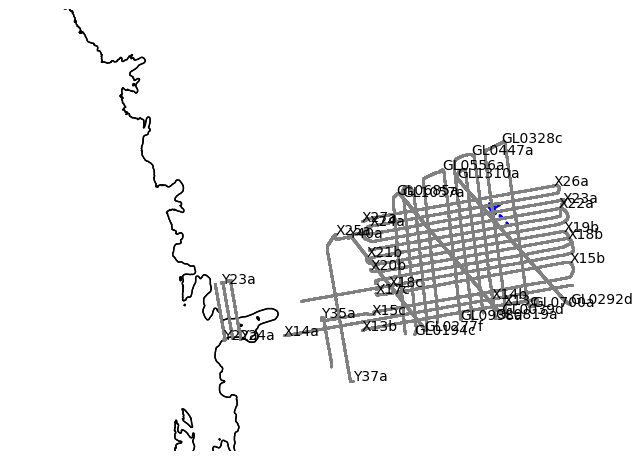

In [8]:
# Make map showing names of each radargram
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': ps71_projection})

bbox = [350000,-1605000,750000,-1320000] #David_SGL2_full
names = [path.split('/')[-1].split('.')[0] for path in file_paths_16_17]


plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=ax, colors=['black','None'],
                    transform=ps71_projection, fill=False, zorder=2, linewidth=1)

ax.patch.set_facecolor("none")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

for radargram in radargrams_16_17:
    ax.scatter(radargram[0].x_coord*100, radargram[0].y_coord*100, s=0.1, color='gray', zorder=3)
    ax.text(radargram[0].x_coord[0]*100, radargram[0].y_coord[0]*100, names[radargrams_16_17.index(radargram)], color='black', fontsize=10, transform=ps71_projection, zorder=4)

for x, y in zip(xs, ys):
    ax.plot(x, y, color='blue', linewidth=1.5)

ax.set_xlim(bbox[0],bbox[2])
ax.set_ylim(bbox[1],bbox[3])

    

In [9]:
# Choose radargram and get along track distance
# Get radargram at index of 'XXX' in names
to_plot = radargrams_16_17[names.index('GL0328c')][0]
x_start = to_plot.x_coord[0]/10
y_start = to_plot.y_coord[0]/10
dist_along_track = np.sqrt((to_plot.x_coord/10 - x_start)**2 + (to_plot.y_coord/10 - y_start)**2)

(-1605000.0, -1320000.0)

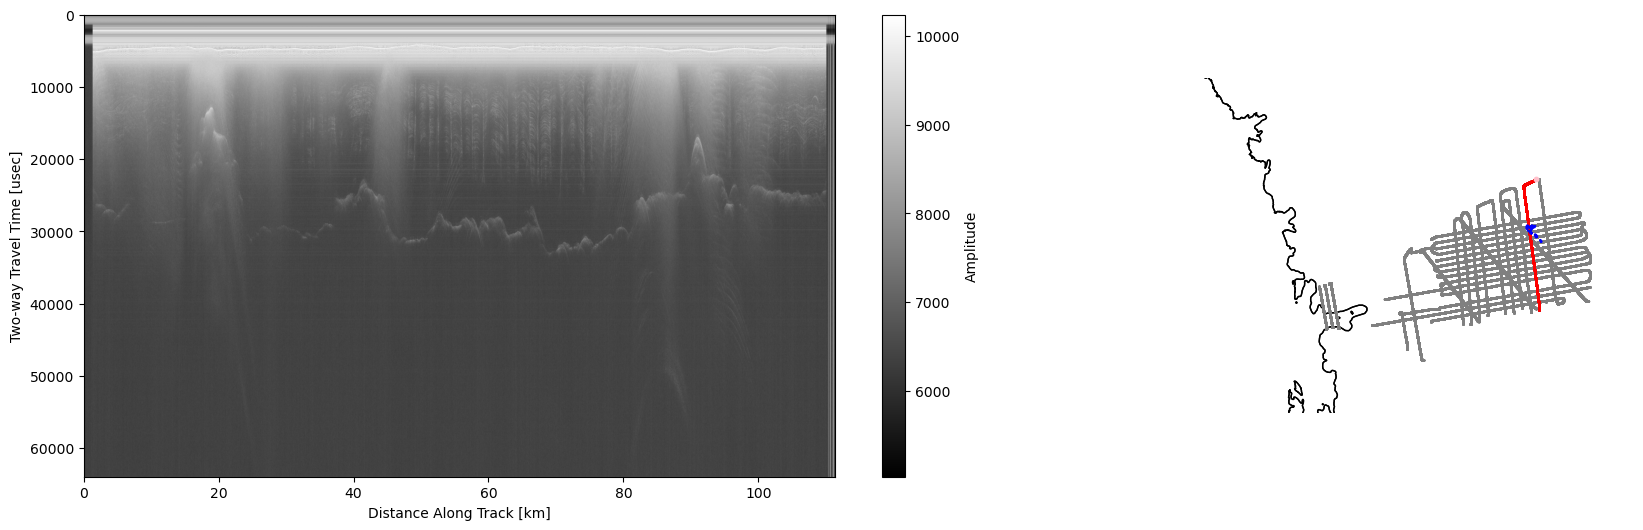

In [10]:
# Plot two panel plot of radargram and position in map of Antarctica
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig = plt.figure(figsize=(20,6))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection=ps71_projection)

### AX1 ###

im = ax1.imshow(to_plot.data, aspect='auto', cmap='gray', extent=[dist_along_track[0], dist_along_track[-1], to_plot.travel_time[-1], to_plot.travel_time[0]])
fig.colorbar(im, ax=ax1, label='Amplitude')
ax1.set_xlabel('Distance Along Track [km]')
ax1.set_ylabel('Two-way Travel Time [usec]')




### AX2 ###
bbox = [350000,-1605000,750000,-1320000] #David_SGL2_full


plot_RINGS_shapefile(records_list=records_full, shapes_list=shapes_full, field_names_list=field_names_full, ax=ax2, colors=['black','None'],
                    transform=ps71_projection, fill=False, zorder=2, linewidth=1)

ax2.patch.set_facecolor("none")
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])

for radargram in radargrams_16_17:
    ax2.scatter(radargram[0].x_coord*100, radargram[0].y_coord*100, s=0.1, color='gray', transform=ps71_projection, zorder=3)

ax2.scatter(to_plot.x_coord*100, to_plot.y_coord*100, s=0.1, color='red', transform=ps71_projection, zorder=4)
ax2.scatter(to_plot.x_coord[0]*100, to_plot.y_coord[0]*100, s=10, color='pink', transform=ps71_projection, zorder=5)


for x, y in zip(xs, ys):
    ax2.plot(x, y, color='blue', linewidth=1.5, zorder=6)

ax2.set_xlim(bbox[0],bbox[2])
ax2.set_ylim(bbox[1],bbox[3])


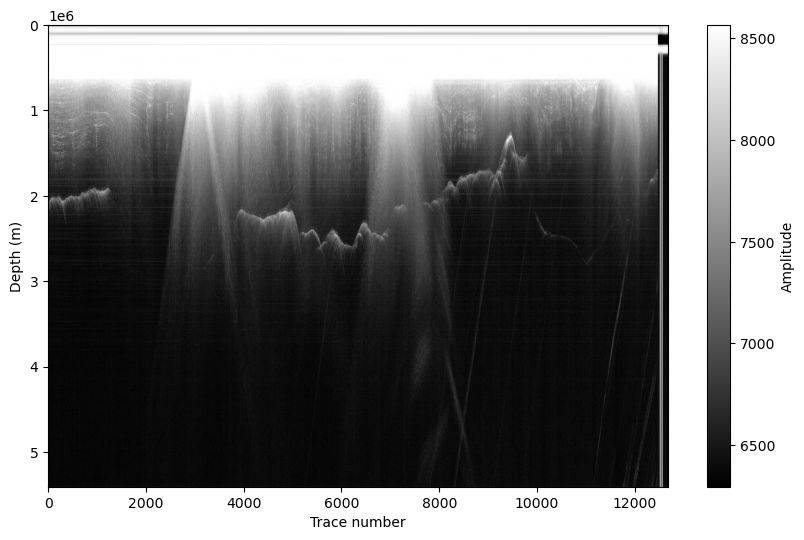

In [5]:
test_rad_gram = radargrams_16_17[0][0]
fig, ax = plt.subplots(figsize=(10, 6))
im, xd, yd, x_range, clims = plot_radargram(test_rad_gram, ydat='depth', xdat='tnum', ax=ax, fig=fig, return_plotinfo=True)
fig.colorbar(im, ax=ax, label='Amplitude')

In [8]:
print(dir(test_rad_gram))
test_rad_gram.chan
test_rad_gram.data.shape, test_rad_gram.data_dtype

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_pick_targ_info', '_parse_stodeepdata', 'adaptivehfilt', 'agc', 'attrs_guaranteed', 'attrs_optional', 'chan', 'check_attrs', 'clean_GPS', 'constant_sample_depth_spacing', 'constant_space', 'crop', 'data', 'data_dtype', 'datetime', 'decday', 'denoise', 'dist', 'dt', 'elev', 'elev_correct', 'flags', 'fn', 'get_ll', 'get_projected_coords', 'hcrop', 'hfilt', 'highpass', 'horizontal_band_pass', 'horizontalfilt', 'lat', 'long', 'lowpass', 'migrate', 'nmo', 'nmo_depth', 'output_csv', 'output_ogr', 'output_shp', 'picks', 'pressure', 'rangegain', 'restack', 'reverse', 'save', 'save_as_segy', 'snum', 'stodeep_attrs', 't_srs', 'tnum', 't

((3200, 12683), dtype('float32'))

(<Figure size 800x1200 with 1 Axes>,
 <Axes: xlabel='Amplitude', ylabel='Two way travel time (usec)'>)

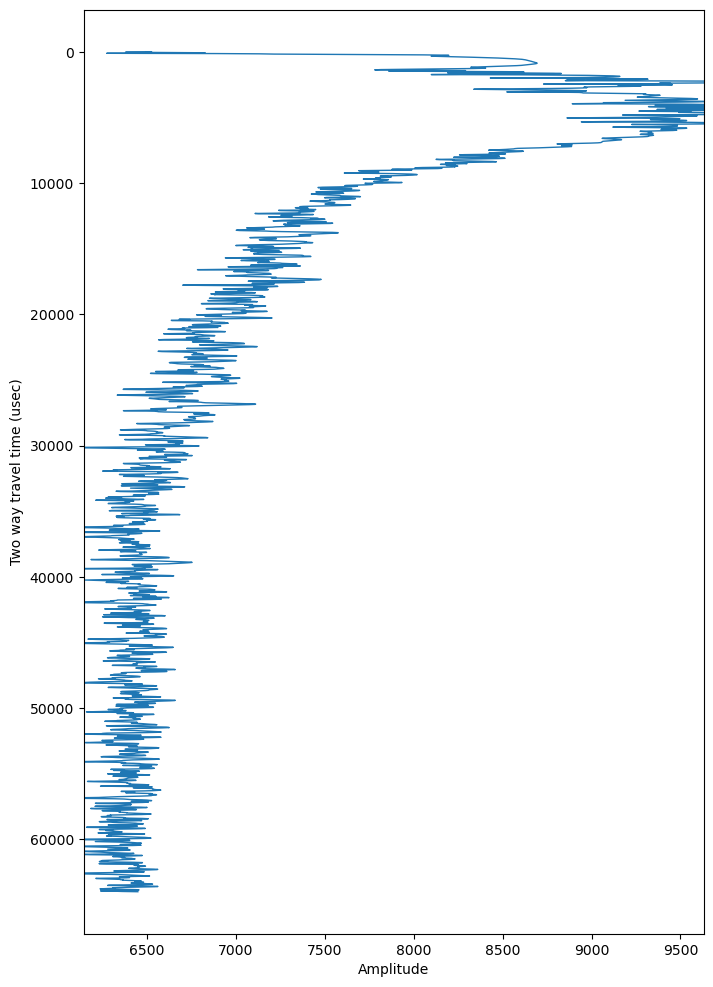

In [33]:
# Plot trace
#test_rad_gram.vertical_band_pass(0.00001,0.01)
plot_traces(test_rad_gram,tr=100)

In [32]:
#file_paths = [os.path.join('./_data/IPR_2016-2017', f) for f in os.listdir('./_data/IPR_2016-2017') if f.endswith('.segy')]
file_paths = [os.path.join('./_data/IPR_2018-2019', f) for f in os.listdir('./_data/IPR_2018-2019') if f.endswith('.segy')]
USEC_TO_SEC = 1e-6

In [33]:
radargrams = [_read_segy(file_paths[i], unpack_trace_headers=True) for i in range(len(file_paths[12:13]))]


In [ ]:
print(rad.traces[0].stats.segy.trace_header.sample_interval_in_ms_for_this_trace)
print(USEC_TO_SEC)


20000

In [34]:
for rad in radargrams[:1]:
    for tr in rad[:1].traces:
        print(tr.stats.segy)

AttribDict({'trace_header': AttribDict({'endian': '>', 'unpacked_header': None, 'trace_sequence_number_within_line': 1, 'trace_sequence_number_within_segy_file': 1, 'original_field_record_number': 1, 'trace_number_within_the_original_field_record': 1, 'energy_source_point_number': 1, 'ensemble_number': 1, 'trace_number_within_the_ensemble': 0, 'trace_identification_code': 0, 'number_of_vertically_summed_traces_yielding_this_trace': 1, 'number_of_horizontally_stacked_traces_yielding_this_trace': 1, 'data_use': 1, 'distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group': 0, 'receiver_group_elevation': 182543, 'surface_elevation_at_source': 182543, 'source_depth_below_surface': 0, 'datum_elevation_at_receiver_group': 182543, 'datum_elevation_at_source': 182543, 'water_depth_at_source': 0, 'water_depth_at_group': 0, 'scalar_to_be_applied_to_all_elevations_and_depths': -100, 'scalar_to_be_applied_to_all_coordinates': -100, 'source_coordinate_x': 65414017, 'source_coord